<a href="https://colab.research.google.com/github/luzyi0/2025-Vision_Computer_TI2B/blob/main/PRAKTIKUM04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRAKTIKUM

## Praktikum D1 - Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
  r = np.random.randint(min_r, max_r + 1) # radius acak
  img = np.zeros((img_size, img_size), dtype=np.uint8)
  cx = np.random.randint(r, img_size - r) # center-x
  cy = np.random.randint(r, img_size - r) # center-y
  cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
  img = (img / 255.0).astype(np.float32)
  # 3-channel biar kompatibel CNN
  img3 = np.stack([img, img, img], axis=-1)
  return img3, float(r), (cx, cy)

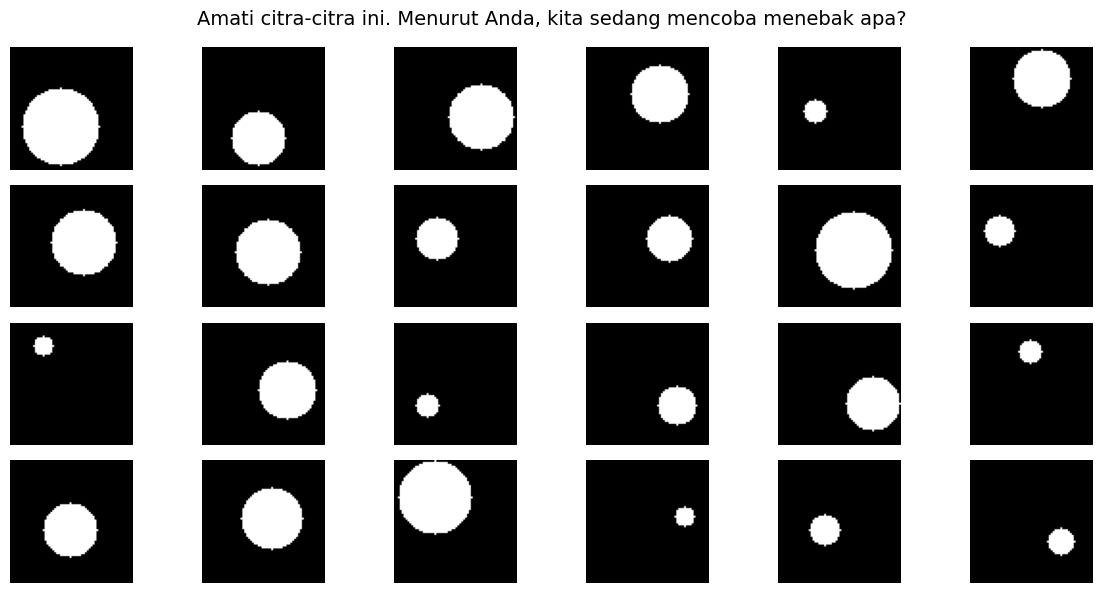

In [2]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]


cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?", fontsize=14)
plt.tight_layout()
plt.show()

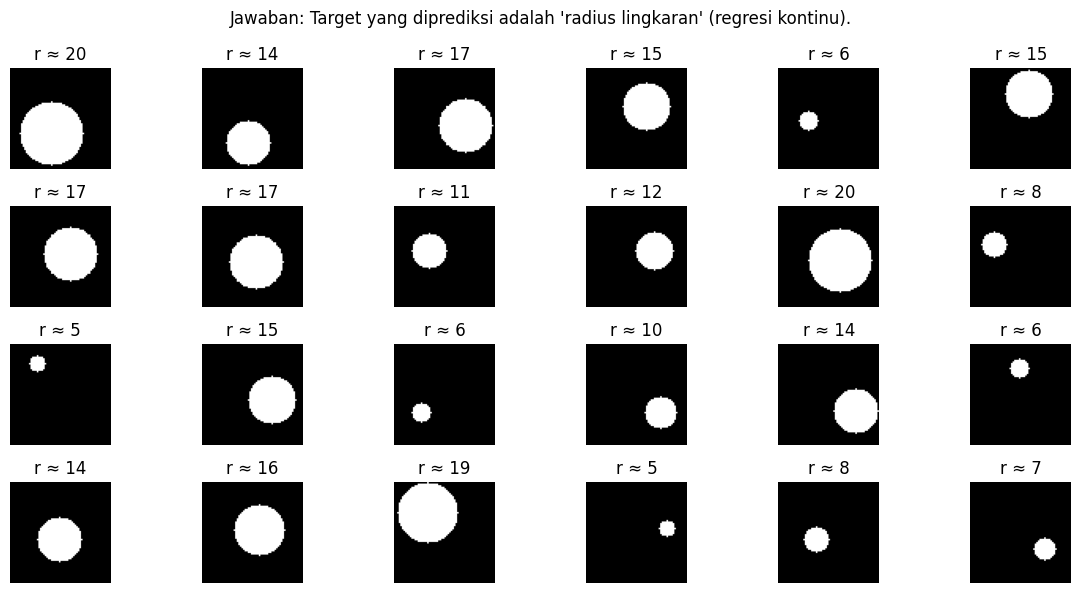

In [3]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.title(f"r ≈ {int(rads[i])}")
  plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

In [4]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # output regresi
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)
# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
MAE=0.927 | RMSE=1.132 | R²=0.937


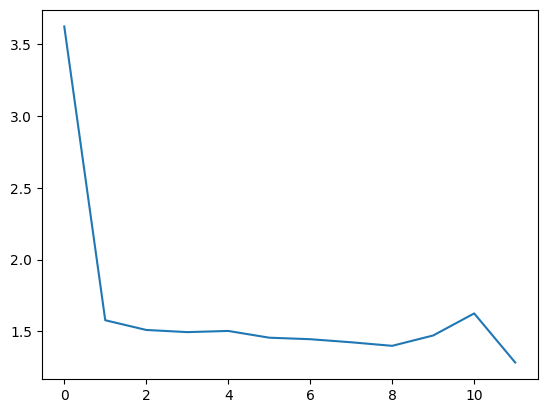

In [5]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch");
plt.ylabel("Loss");
plt.legend();
plt.show()

# Scatter True vs Pred plt.figure(figsize=(5,5)) plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius");
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

## Praktikum D2 - Menebak Umur Manusia dari Foto Wajah (UTKFace)

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"septiaisnaeni","key":"42ba917d8e716c1143fdd71cf7539d77"}'}

In [7]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copyfile("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("Kaggle API siap digunakan.")
else:
  print("kaggle.json belum ditemukan. Upload terlebih dahulu.")

Kaggle API siap digunakan.


In [8]:
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


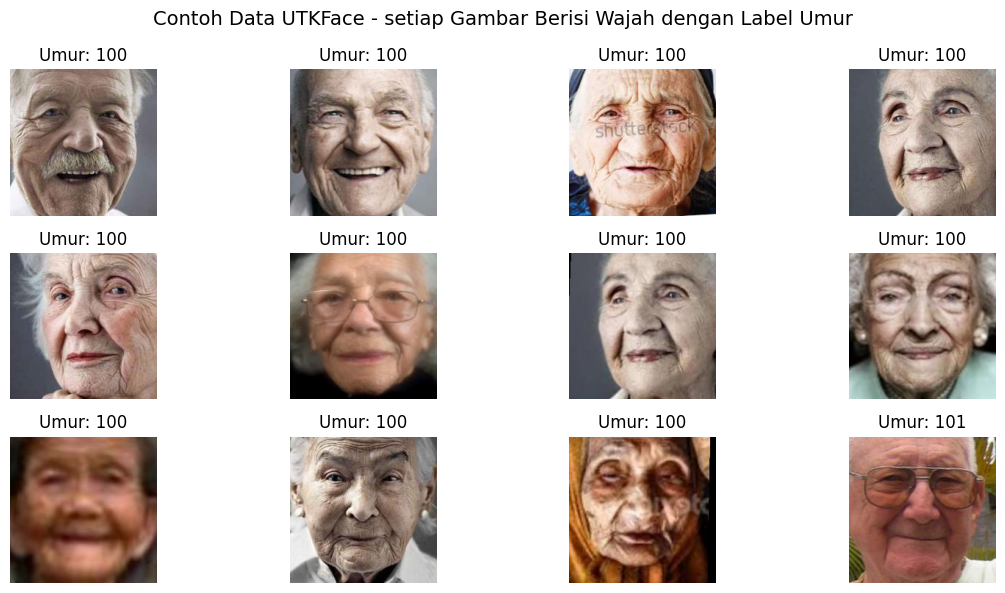

In [10]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
  age = int(os.path.basename(f).split("_") [0])
  img = Image.open(f)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Umur: {age}")
  plt.axis('off')
plt.suptitle("Contoh Data UTKFace - setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
  return int(os.path.basename(fp).split("_")[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160
def load_img(fp, label):
  img = tf.io.read_file(fp)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)

print("Dataset siap dilatih")

Dataset siap dilatih


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices("GPU") else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False # Tahap awal :freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x - layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # Output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi mode
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])

model.summary

Hardware: CPU


<bound method Model.summary of <Functional name=functional_3, built=True>>

In [ ]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True,
  monitor='val_loss')
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]S

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)